## Exp-037 (ULMS BERT)

In [ ]:
!nvidia-smi

Fri Sep 17 05:57:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers pycld2

     |████████████████████████████████| 2.8 MB 7.1 MB/s 
     |████████████████████████████████| 41.4 MB 63 kB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
     |████████████████████████████████| 3.3 MB 64.4 MB/s 
     |████████████████████████████████| 636 kB 77.4 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834418 sha256=21cb9789cba78c458458b3f82263c4a97c123fdd1ee95c59314fefd9a999a32e
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
input_dir = "/content/drive/MyDrive/07_Competition/signate-471/data/"
output_dir = "/content/drive/MyDrive/07_Competition/signate-471/log/"
submission_dir = "/content/drive/MyDrive/07_Competition/signate-471/submission/"
model_dir = "/content/drive/MyDrive/07_Competition/signate-471/model_bin/"
pred_dir = "/content/drive/MyDrive/07_Competition/signate-471/pred/"

In [ ]:
import os
import math
import random
import pandas as pd
import numpy as np
from glob import glob
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

from transformers import BertConfig, RobertaConfig
from transformers import (get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertModel, RobertaModel
from transformers import AutoConfig, BertConfig, RobertaConfig
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from torch import cuda
import time

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
from transformers import get_linear_schedule_with_warmup

from IPython.display import clear_output
from tqdm import tqdm, trange

import re
import nltk
import pycld2 as cld2
from scipy.optimize import minimize, minimize_scalar
import regex
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class CFG:
  exp = "exp37h"
  seed = 71
  fold = 5
  max_len = 280
  epochs = 1
  lr = 2e-5
  train_batch_size = 16
  valid_batch_size = 32
  model_name = "GanjinZero/UMLSBert_ENG"

CONFIG = CFG()

In [ ]:
os.makedirs(model_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(pred_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(output_dir+CONFIG.exp+"/", exist_ok=True)

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

set_random_seed(CONFIG.seed)

In [ ]:
DEVICE = torch.device('cuda') if cuda.is_available() else 'cpu'

In [ ]:
def init_logger(log_file=output_dir + CONFIG.exp+ f"/{CONFIG.exp}_train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
def get_train_data(train):
    # 交差検証 用の番号を振ります。
    Fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

def get_test_data(test):
    return test

In [ ]:
class SRWSDataset(Dataset):
  def __init__(self, df, inference_only=False):

    # Berttokenizer
    tokenizer = BertTokenizer.from_pretrained(CONFIG.model_name)

    self.df = df
    self.inference_only = inference_only # "train":False or "test":True
    self.text = self.df["title_abst"].tolist() # text

    if not self.inference_only:
      # ここvalueだけ
      self.target = df["judgement"].values
      
    self.encoded = tokenizer.batch_encode_plus(
        self.text,
        padding = "max_length",
        max_length = CONFIG.max_len,
        truncation = True,
        return_attention_mask=True
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    input_ids = torch.tensor(self.encoded["input_ids"][index])
    attention_mask = torch.tensor(self.encoded["attention_mask"][index])

    # returnをsetかdictで返すかは自由
    if self.inference_only:
      return (input_ids, attention_mask)

    else:
      # ここで、tensor に変更している
      target = torch.tensor(self.target[index]).float()
      return (input_ids, attention_mask, target)


In [ ]:
class SRWSBertModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.config = BertConfig.from_pretrained(CFG.model_name)
    self.config.update({"output_hidden_states": True})
    self.config.hidden_dropout_prob = 0
    self.config.attention_probs_dropout_prob = 0
    self.bert = BertModel.from_pretrained(CONFIG.model_name, config=self.config)
    self.regressor = nn.Linear(self.config.hidden_size*4, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
    sequence_output = torch.cat([output["hidden_states"][-1*i][:,0] for i in range(1, 4+1)], dim=1)
    bert_output = self.regressor(sequence_output)
    bert_output = self.sigmoid(bert_output).squeeze()

    return bert_output

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
# 学習
def train_fn(model, train_loader, optimizer, epoch, loss_function, scheduler=None):
  start = end = time.time()
  losses = AverageMeter()
  model.train()

  for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
    optimizer.zero_grad()

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    pred = model(input_ids, attention_mask)

    # Loss算出
    #print(pred)
    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)
    loss.backward()

    optimizer.step()

    if scheduler:
      scheduler.step()

    if batch_num % 100 == 0 or batch_num == (len(train_loader) -1):
      print(
            f"Epoch: [{epoch + 1}][{batch_num}/{len(train_loader)}] "
            f"Elapsed {timeSince(start, float(batch_num + 1) / len(train_loader)):s} "
            f"Loss: {losses.avg:.4f} "
            )
      
  return losses.avg

def valid_fn(valid_loader, model, loss_function):
  start = end = time.time()
  losses = AverageMeter()

  model.eval()
  preds = []

  for batch_num, (input_ids, attention_mask, target) in enumerate(valid_loader):
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    # compare loss
    with torch.no_grad():
      pred = model(input_ids, attention_mask)

    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)

    # スコア追加
    preds.append(pred.to("cpu").numpy())

    if batch_num % 100 == 0 or batch_num == (len(valid_loader) - 1):
      print(
          f"EVAL: [{batch_num}/{len(valid_loader)}]"
          f"Elapsed {timeSince(start, float(batch_num+1) / len(valid_loader)):s}"
          f"Loss: {losses.avg:.4f}"
      )
  predictions = np.concatenate(preds)

  return losses.avg, predictions

# 予測
def inference():
    predictions = []

    test_dataset = SRWSDataset(test,  inference_only=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG.valid_batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    for fold in range(CONFIG.fold):
        LOGGER.info(f"========== model: {CONFIG.model_name} fold: {fold} inference ==========")
        model = SRWSBertModel()
        model.to(DEVICE)
        model.load_state_dict(torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")["model"])
        model.eval()
        preds = []
        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            with torch.no_grad():
                y_preds = model(input_ids, attention_mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

In [ ]:
# 最適化（使ってない）
# https://signate.jp/competitions/471/discussions/tf-roberta-base-baseline-cv08949-lb08734

def opt_fbeta_threshold(y_true, y_pred):
  """fbeta score計算時のthresholdを最適化"""
  def opt_(x):
    return -fbeta_score(y_true, y_pred >= x, beta=7)
  result = minimize(opt_, x0=np.array([0.02]), method='Powell')
  best_threshold = result['x'].item()
  return best_threshold

In [ ]:
def get_optimizer_grouped_parameters(model):
    model_type = 'bert'
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 1e-3,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = CONFIG.lr
    for layer in layers:
        lr *= 0.95
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.1,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [ ]:
# LOOP
def train_loop(train, fold):
  LOGGER.info(f"========== fold: {fold} training ==========")

  # ====================================================
  # Data Loader
  # ====================================================
  trn_idx = train[train["fold"] != fold].index
  val_idx = train[train["fold"] == fold].index

  train_folds = train.loc[trn_idx].reset_index(drop=True)
  valid_folds = train.loc[val_idx].reset_index(drop=True)

  train_dataset = SRWSDataset(train_folds)
  valid_dataset = SRWSDataset(valid_folds)

  train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, # https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
        drop_last=True,
  )
  valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.valid_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
  )

  # ====================================================
  # Model
  # ====================================================
  model = SRWSBertModel()
  model.to(DEVICE)

  optimizer_parameters = get_optimizer_grouped_parameters(model)

  #optimizer = AdamW(model.parameters(), lr=CONFIG.lr)
  optimizer = AdamW(optimizer_parameters, lr=CONFIG.lr, weight_decay=0.1)

  # Loss_function
  loss_function = nn.BCELoss()

  # ====================================================
  # LOOP
  # ====================================================

  best_score = -1
  best_loss = np.inf
  best_borders=[]

  # 学習
  for epoch in range(CONFIG.epochs):
    start_time = time.time()

    # train
    avg_loss = train_fn(model, train_loader, optimizer, epoch, loss_function)

    # valid
    avg_val_loss, preds = valid_fn(valid_loader, model,loss_function)
    valid_labels = valid_folds["judgement"].values

    # border最適化
    border_m = opt_fbeta_threshold(valid_labels, preds)
    best_borders.append(border_m)

    # score
    score = fbeta_score(valid_labels, np.where(preds < border_m, 0, 1), beta=7.0)

    elapsed = time.time() - start_time
    LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
    )
    LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

    if score > best_score:
      best_score = score
      LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} ")
      torch.save(
                {"model": model.state_dict(), "preds": preds}, model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth"
      ) # scibertでの変更
  check_point = torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")

  valid_folds["preds"] = check_point["preds"]

  return valid_folds,best_borders

In [ ]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_threshold))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_threshold, 0, 1), beta=7.0)
    print("Score：" + str(score))
    LOGGER.info(f"Score: {score:<.5f}")

# inference用に、best_thresholdを出力するようにする関数
def get_result_for_cv(result_df,best_border):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    #best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_border))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_border, 0, 1), beta=7.0)
    LOGGER.info(f"Score: {score:<.5f}")

    return score

def mean_best_border(*best_borders):
    best_border = np.mean(best_borders)
    print("Best_Threshold：" + str(best_border))
    LOGGER.info(f"Best_Border: {best_border:<.8f}")

    return best_border

In [ ]:
def clean_stopword(text):
  stopwords = nltk.corpus.stopwords.words('english')
  list_x = text.split()
  res = []
  for w in list_x:
    if w not in stopwords:
      res.append(w)
  return ' '.join(res)

def clean_puncts(x):
  # 化学式とかがあるから '-'は削除しないほうがいいか？

  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
            '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
            '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
            '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
            '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '（', '）', '～',
            '➡', '％', '⇒', '▶', '「', '➄', '➆',  '➊', '➋', '➌', '➍', '⓪', '①', '②', '③', '④', '⑤', '⑰', '❶', '❷', '❸', '❹', '❺', '❻', '❼', '❽',  
            '＝', '※', '㈱', '､', '△', '℮', 'ⅼ', '‐', '｣', '┝', '↳', '◉', '／', '＋', '○',
            '【', '】', '✅', '☑', '➤', 'ﾞ', '↳', '〶', '☛', '｢', '⁺', '『', '≫',
            'Â©', '<sub>','Aﾎｲ', 'ﾎｲ', "ﾃｩ"
          ] 
  # 文字化け対応はここで対応するしかない？
  
  for punct in puncts:
    x = x.replace(punct, '')
  return x

def _pre_preprocess(x):
  return str(x).lower() 

def rm_num(x, use_num=True):
  numbers = ["0","1","2","3","4","5","6","7","8","9","０","１","２","３","４","５","６","７","８","９"]
  x = re.sub('[0-9]{5,}', '', x)
  x = re.sub('[0-9]{4}', '', x)
  x = re.sub('[0-9]{3}', '', x)
  x = re.sub('[0-9]{2}', '', x)    
  for i in numbers:
    x = x.replace(str(i), '')        
  return x

def convert_mojibake(text):
  text = text.encode("shift-jis").decode("utf-8", errors="ignore")
  return text

def remove_double(text):
  text = text.replace("  ", " ")
  return text

def preprocess_text(text):
  #text = _pre_preprocess(text)
  #text = clean_stopword(text)
  text = clean_puncts(text)
  text = rm_num(text)
  text = remove_double(text)

  return text

def split_copyright(text):
  if "Copyright" in text:
    text = text.split('Copyright')[0]
    return text
  else:
    return text


In [ ]:
pd.set_option("display.max_colwidth", 50)
train = pd.read_csv(input_dir + "train.csv")
test = pd.read_csv(input_dir + "test.csv")
sub = pd.read_csv(input_dir + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

In [ ]:
# ラベル変更
# https://signate.jp/competitions/471/discussions/20210816152356-59

train.loc[train["id"]==2488, "judgement"] = 0
train.loc[train["id"]==7708, "judgement"] = 0

In [ ]:
train = get_train_data(train)
train.head()

,id,title,abstract,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1


In [ ]:
train["title_abst"] = train["title"] + train["abstract"]
train["title_abst"].fillna(train["title"], inplace=True)

test["title_abst"] = test["title"] + test["abstract"]
test["title_abst"].fillna(test["title"], inplace=True)

train.head()

,id,title,abstract,judgement,fold,title_abst
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1,Prolonged shedding of SARS-CoV-2 in an elderly...


In [ ]:
# preprocess
train["title_abst"] = train["title_abst"].apply(lambda x: preprocess_text(x))
test["title_abst"] = test["title_abst"].apply(lambda x: preprocess_text(x))

# titleの単語数が3以下のものは除外してみる
train["title_word_len"] = train["title"].str.split(" ").str.len()
train = train[train["title_word_len"]>3]

# titleが他言語の場合は除外
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train = train[(train["title_lang"]=="en")|(train["title_lang"]=="un")]

# copyright以降は削除したい
train["title_abst"] = train["title_abst"].apply(lambda x: split_copyright(x))
test["title_abst"] = test["title_abst"].apply(lambda x: split_copyright(x))

In [ ]:
# 文字化け対応

bake_list = []
for text in train["title_abst"].dropna().tolist():
  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
            '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
            '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
            '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
            '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '（', '）', '～',
            '➡', '％', '⇒', '▶', '「', '➄', '➆',  '➊', '➋', '➌', '➍', '⓪', '①', '②', '③', '④', '⑤', '⑰', '❶', '❷', '❸', '❹', '❺', '❻', '❼', '❽',  
            '＝', '※', '㈱', '､', '△', '℮', 'ⅼ', '‐', '｣', '┝', '↳', '◉', '／', '＋', '○',
            '【', '】', '✅', '☑', '➤', 'ﾞ', '↳', '〶', '☛', '｢', '⁺', '『', '≫',
            'Â©', '<sub>','Aﾎｲ', 'ﾎｲ', "ﾃｩ"
          ] 
  # 一旦、わかっている除外文字を除いていく
  for punct in puncts:
    text = text.replace(punct, '')
  # 数字を除外
  text = rm_num(text)

  # 二重空白を除外
  text = remove_double(text)

  # 英語以外の単語をリストに
  pickup_list = re.findall(r"[^a-zA-Z]+", text)

  for i in pickup_list:
    if not i.isspace():
      i = i.replace(" ", "")
      bake_list.append(i)

In [ ]:
# リストに変更
bake_word = set(bake_list)
drop_bake = list(bake_word)

In [ ]:
def clean_bake(x):
  # drop_bakeのリストがないと動かない
  for bake in drop_bake:
    x = x.replace(bake, '')
  return x

train["title_abst"] = train["title_abst"].apply(lambda x: clean_bake(x))
test["title_abst"] = test["title_abst"].apply(lambda x: clean_bake(x))

In [ ]:
print(len(pd.read_csv(input_dir + "train.csv")))
print(len(train))

27145
26921


In [ ]:
train

,id,title,abstract,judgement,fold,title_abst,title_word_len,title_lang
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,Oneyear age changes in MRI brain volumes in ol...,10,en
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3,Supportive CSF biomarker evidence to enhance t...,23,en
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,Occurrence of basal ganglia germ cell tumors w...,10,en
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...,13,en
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1,Prolonged shedding of SARSCoV in an elderly li...,16,en
...,...,...,...,...,...,...,...,...
27140,27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,0,1,The amyloidogenic pathway of amyloid precursor...,15,en
27141,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0,4,Technologic developments in radiotherapy and s...,7,en
27142,27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,0,2,Novel screening cascade identifies MKK as key ...,13,en
27143,27143,Visualization of the gall bladder on F-18 FDOP...,The ability to label dihydroxyphenylalanine (D...,0,2,Visualization of the gall bladder on F FDOPA P...,13,en


# ALL

## 学習#1 (42:1)

In [ ]:


mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df_42_1.csv", index=False)

========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/1345] Elapsed 0m 1s (remain 22m 35s) Loss: 0.9644 
Epoch: [1][100/1345] Elapsed 1m 18s (remain 16m 4s) Loss: 0.1182 
Epoch: [1][200/1345] Elapsed 2m 39s (remain 15m 10s) Loss: 0.0939 
Epoch: [1][300/1345] Elapsed 4m 4s (remain 14m 6s) Loss: 0.0871 
Epoch: [1][400/1345] Elapsed 5m 28s (remain 12m 52s) Loss: 0.0809 
Epoch: [1][500/1345] Elapsed 6m 52s (remain 11m 35s) Loss: 0.0772 
Epoch: [1][600/1345] Elapsed 8m 17s (remain 10m 15s) Loss: 0.0740 
Epoch: [1][700/1345] Elapsed 9m 41s (remain 8m 54s) Loss: 0.0708 
Epoch: [1][800/1345] Elapsed 11m 5s (remain 7m 32s) Loss: 0.0688 
Epoch: [1][900/1345] Elapsed 12m 29s (remain 6m 9s) Loss: 0.0663 
Epoch: [1][1000/1345] Elapsed 13m 54s (remain 4m 46s) Loss: 0.0640 
Epoch: [1][1100/1345] Elapsed 15m 18s (remain 3m 23s) Loss: 0.0620 
Epoch: [1][1200/1345] Elapsed 16m 42s (remain 2m 0s) Loss: 0.0606 
Epoch: [1][1300/1345] Elapsed 18m 7s (remain 0m 36s) Loss: 0.0588 
Epoch: [1][1344/1345] Elapsed 18m 44s (remain 0m 0s) Loss: 0.0583 
EV

Epoch 1 - avg_train_loss: 0.0583  avg_val_loss: 0.0441  time: 1220s
Epoch 1 - Score: 0.9099250649946475
Epoch 1 - Save Best Score: 0.9099 
========== fold: 0 result ==========
Best_Border: 0.03809500
========== fold: 1 training ==========


Best_Threshold：0.03809500077042853


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/1346] Elapsed 0m 0s (remain 21m 54s) Loss: 1.3753 
Epoch: [1][100/1346] Elapsed 1m 22s (remain 16m 53s) Loss: 0.1113 
Epoch: [1][200/1346] Elapsed 2m 46s (remain 15m 47s) Loss: 0.0894 
Epoch: [1][300/1346] Elapsed 4m 10s (remain 14m 29s) Loss: 0.0798 
Epoch: [1][400/1346] Elapsed 5m 34s (remain 13m 9s) Loss: 0.0749 
Epoch: [1][500/1346] Elapsed 6m 59s (remain 11m 47s) Loss: 0.0683 
Epoch: [1][600/1346] Elapsed 8m 23s (remain 10m 24s) Loss: 0.0677 
Epoch: [1][700/1346] Elapsed 9m 48s (remain 9m 1s) Loss: 0.0649 
Epoch: [1][800/1346] Elapsed 11m 12s (remain 7m 37s) Loss: 0.0648 
Epoch: [1][900/1346] Elapsed 12m 36s (remain 6m 13s) Loss: 0.0637 
Epoch: [1][1000/1346] Elapsed 14m 0s (remain 4m 49s) Loss: 0.0610 
Epoch: [1][1100/1346] Elapsed 15m 24s (remain 3m 25s) Loss: 0.0592 
Epoch: [1][1200/1346] Elapsed 16m 49s (remain 2m 1s) Loss: 0.0577 
Epoch: [1][1300/1346] Elapsed 18m 13s (remain 0m 37s) Loss: 0.0569 
Epoch: [1][1345/1346] Elapsed 18m 51s (remain 0m 0s) Loss: 0.0566 

Epoch 1 - avg_train_loss: 0.0566  avg_val_loss: 0.0422  time: 1227s
Epoch 1 - Score: 0.9107607530996481
Epoch 1 - Save Best Score: 0.9108 
========== fold: 1 result ==========
Best_Border: 0.02848985
========== fold: 2 training ==========


Best_Threshold：0.028489848535984744


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/1345] Elapsed 0m 0s (remain 22m 20s) Loss: 0.5700 
Epoch: [1][100/1345] Elapsed 1m 22s (remain 16m 54s) Loss: 0.1045 
Epoch: [1][200/1345] Elapsed 2m 46s (remain 15m 47s) Loss: 0.0929 
Epoch: [1][300/1345] Elapsed 4m 10s (remain 14m 28s) Loss: 0.0792 
Epoch: [1][400/1345] Elapsed 5m 34s (remain 13m 8s) Loss: 0.0784 
Epoch: [1][500/1345] Elapsed 6m 59s (remain 11m 46s) Loss: 0.0765 
Epoch: [1][600/1345] Elapsed 8m 23s (remain 10m 23s) Loss: 0.0724 
Epoch: [1][700/1345] Elapsed 9m 47s (remain 8m 59s) Loss: 0.0682 
Epoch: [1][800/1345] Elapsed 11m 11s (remain 7m 36s) Loss: 0.0659 
Epoch: [1][900/1345] Elapsed 12m 36s (remain 6m 12s) Loss: 0.0636 
Epoch: [1][1000/1345] Elapsed 14m 0s (remain 4m 48s) Loss: 0.0619 
Epoch: [1][1100/1345] Elapsed 15m 24s (remain 3m 24s) Loss: 0.0601 
Epoch: [1][1200/1345] Elapsed 16m 48s (remain 2m 0s) Loss: 0.0577 
Epoch: [1][1300/1345] Elapsed 18m 13s (remain 0m 36s) Loss: 0.0574 
Epoch: [1][1344/1345] Elapsed 18m 50s (remain 0m 0s) Loss: 0.0572

Epoch 1 - avg_train_loss: 0.0572  avg_val_loss: 0.0482  time: 1226s
Epoch 1 - Score: 0.9182736455463727
Epoch 1 - Save Best Score: 0.9183 
========== fold: 2 result ==========
Best_Border: 0.07781185
========== fold: 3 training ==========


Best_Threshold：0.07781184640786215


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/1346] Elapsed 0m 0s (remain 21m 48s) Loss: 0.6843 
Epoch: [1][100/1346] Elapsed 1m 22s (remain 17m 1s) Loss: 0.0741 
Epoch: [1][200/1346] Elapsed 2m 47s (remain 15m 51s) Loss: 0.0767 
Epoch: [1][300/1346] Elapsed 4m 11s (remain 14m 32s) Loss: 0.0730 
Epoch: [1][400/1346] Elapsed 5m 35s (remain 13m 10s) Loss: 0.0692 
Epoch: [1][500/1346] Elapsed 6m 59s (remain 11m 48s) Loss: 0.0693 
Epoch: [1][600/1346] Elapsed 8m 24s (remain 10m 25s) Loss: 0.0666 
Epoch: [1][700/1346] Elapsed 9m 48s (remain 9m 1s) Loss: 0.0644 
Epoch: [1][800/1346] Elapsed 11m 12s (remain 7m 37s) Loss: 0.0644 
Epoch: [1][900/1346] Elapsed 12m 37s (remain 6m 14s) Loss: 0.0635 
Epoch: [1][1000/1346] Elapsed 14m 1s (remain 4m 50s) Loss: 0.0612 
Epoch: [1][1100/1346] Elapsed 15m 25s (remain 3m 26s) Loss: 0.0601 
Epoch: [1][1200/1346] Elapsed 16m 49s (remain 2m 1s) Loss: 0.0578 
Epoch: [1][1300/1346] Elapsed 18m 14s (remain 0m 37s) Loss: 0.0578 
Epoch: [1][1345/1346] Elapsed 18m 52s (remain 0m 0s) Loss: 0.0574 

Epoch 1 - avg_train_loss: 0.0574  avg_val_loss: 0.0617  time: 1228s
Epoch 1 - Score: 0.9291698400609292
Epoch 1 - Save Best Score: 0.9292 
========== fold: 3 result ==========
Best_Border: 0.00220076
========== fold: 4 training ==========


Best_Threshold：0.002200764883934379


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/1346] Elapsed 0m 1s (remain 22m 54s) Loss: 0.9500 
Epoch: [1][100/1346] Elapsed 1m 25s (remain 17m 35s) Loss: 0.1213 
Epoch: [1][200/1346] Elapsed 2m 49s (remain 16m 7s) Loss: 0.1005 
Epoch: [1][300/1346] Elapsed 4m 13s (remain 14m 41s) Loss: 0.0891 
Epoch: [1][400/1346] Elapsed 5m 38s (remain 13m 16s) Loss: 0.0787 
Epoch: [1][500/1346] Elapsed 7m 2s (remain 11m 52s) Loss: 0.0747 
Epoch: [1][600/1346] Elapsed 8m 26s (remain 10m 28s) Loss: 0.0716 
Epoch: [1][700/1346] Elapsed 9m 50s (remain 9m 3s) Loss: 0.0689 
Epoch: [1][800/1346] Elapsed 11m 15s (remain 7m 39s) Loss: 0.0667 
Epoch: [1][900/1346] Elapsed 12m 39s (remain 6m 14s) Loss: 0.0653 
Epoch: [1][1000/1346] Elapsed 14m 3s (remain 4m 50s) Loss: 0.0644 
Epoch: [1][1100/1346] Elapsed 15m 27s (remain 3m 26s) Loss: 0.0629 
Epoch: [1][1200/1346] Elapsed 16m 52s (remain 2m 2s) Loss: 0.0605 
Epoch: [1][1300/1346] Elapsed 18m 16s (remain 0m 37s) Loss: 0.0586 
Epoch: [1][1345/1346] Elapsed 18m 53s (remain 0m 0s) Loss: 0.0585 


Epoch 1 - avg_train_loss: 0.0585  avg_val_loss: 0.0484  time: 1230s
Epoch 1 - Score: 0.8589835361488904
Epoch 1 - Save Best Score: 0.8590 
========== fold: 4 result ==========
Best_Border: 0.00236850
========== CV ==========
Best_Border: 0.02979319
Score: 0.86257


Best_Threshold：0.002368500663387937
Best_Threshold：0.02979319225231955
Best_Threshold：0.02979319225231955


In [ ]:
best_border

0.02979319225231955

## 予測#1(42:1)

In [ ]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df_42_1.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission_42_1.csv", index=False, header=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [12:02<00:00,  1.77it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [12:02<00:00,  1.77it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [12:01<00:00,  1.77it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [12:01<00:00,  1.77it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 in

## 学習#2 (20:1)

In [ ]:
#学習#1のうち０ラベルの予測に近いデータを削除
#0,1ラベル比を20:1にする

oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df_42_1.csv")
oof_df_negative = oof_df[oof_df.judgement ==0].sort_values("preds",ascending=True).reset_index()
oof_df_positive = oof_df[oof_df.judgement ==1]

cut_line=len(oof_df) - 624*21
oof_df_negative = oof_df_negative[cut_line:]
train = pd.concat([oof_df_negative,oof_df_positive],axis=0).reset_index(drop=True)
train = get_train_data(train)

In [ ]:
train.judgement.value_counts()

0    12480
1      624
Name: judgement, dtype: int64

In [ ]:
mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df_20_1.csv", index=False)



========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/655] Elapsed 0m 1s (remain 11m 16s) Loss: 0.5864 
Epoch: [1][100/655] Elapsed 1m 25s (remain 7m 47s) Loss: 0.1614 
Epoch: [1][200/655] Elapsed 2m 49s (remain 6m 22s) Loss: 0.1514 
Epoch: [1][300/655] Elapsed 4m 12s (remain 4m 57s) Loss: 0.1385 
Epoch: [1][400/655] Elapsed 5m 37s (remain 3m 33s) Loss: 0.1287 
Epoch: [1][500/655] Elapsed 7m 1s (remain 2m 9s) Loss: 0.1227 
Epoch: [1][600/655] Elapsed 8m 24s (remain 0m 45s) Loss: 0.1191 
Epoch: [1][654/655] Elapsed 9m 10s (remain 0m 0s) Loss: 0.1144 
EVAL: [0/82]Elapsed 0m 0s (remain 0m 57s)Loss: 0.0015


Epoch 1 - avg_train_loss: 0.1144  avg_val_loss: 0.0785  time: 597s
Epoch 1 - Score: 0.9010408575423334
Epoch 1 - Save Best Score: 0.9010 


EVAL: [81/82]Elapsed 0m 46s (remain 0m 0s)Loss: 0.0785


========== fold: 0 result ==========
Best_Border: 0.05769110
========== fold: 1 training ==========


Best_Threshold：0.057691101187707844


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/655] Elapsed 0m 1s (remain 11m 16s) Loss: 0.7805 
Epoch: [1][100/655] Elapsed 1m 25s (remain 7m 47s) Loss: 0.1781 
Epoch: [1][200/655] Elapsed 2m 49s (remain 6m 22s) Loss: 0.1487 
Epoch: [1][300/655] Elapsed 4m 13s (remain 4m 57s) Loss: 0.1376 
Epoch: [1][400/655] Elapsed 5m 37s (remain 3m 33s) Loss: 0.1300 
Epoch: [1][500/655] Elapsed 7m 1s (remain 2m 9s) Loss: 0.1232 
Epoch: [1][600/655] Elapsed 8m 25s (remain 0m 45s) Loss: 0.1139 
Epoch: [1][654/655] Elapsed 9m 10s (remain 0m 0s) Loss: 0.1111 
EVAL: [0/82]Elapsed 0m 0s (remain 0m 59s)Loss: 0.0010
EVAL: [81/82]Elapsed 0m 46s (remain 0m 0s)Loss: 0.0926


Epoch 1 - avg_train_loss: 0.1111  avg_val_loss: 0.0926  time: 597s
Epoch 1 - Score: 0.9181969949916526
Epoch 1 - Save Best Score: 0.9182 
========== fold: 1 result ==========
Best_Border: 0.00421235
========== fold: 2 training ==========


Best_Threshold：0.004212354378032376


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/655] Elapsed 0m 1s (remain 11m 15s) Loss: 0.4065 
Epoch: [1][100/655] Elapsed 1m 25s (remain 7m 48s) Loss: 0.1598 
Epoch: [1][200/655] Elapsed 2m 49s (remain 6m 22s) Loss: 0.1477 
Epoch: [1][300/655] Elapsed 4m 13s (remain 4m 57s) Loss: 0.1363 
Epoch: [1][400/655] Elapsed 5m 37s (remain 3m 33s) Loss: 0.1286 
Epoch: [1][500/655] Elapsed 7m 1s (remain 2m 9s) Loss: 0.1242 
Epoch: [1][600/655] Elapsed 8m 25s (remain 0m 45s) Loss: 0.1166 
Epoch: [1][654/655] Elapsed 9m 10s (remain 0m 0s) Loss: 0.1158 
EVAL: [0/82]Elapsed 0m 0s (remain 0m 59s)Loss: 0.0007
EVAL: [81/82]Elapsed 0m 46s (remain 0m 0s)Loss: 0.0936


Epoch 1 - avg_train_loss: 0.1158  avg_val_loss: 0.0936  time: 597s
Epoch 1 - Score: 0.8706467661691543
Epoch 1 - Save Best Score: 0.8706 
========== fold: 2 result ==========
Best_Border: 0.03037711
========== fold: 3 training ==========


Best_Threshold：0.030377105418709003


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/655] Elapsed 0m 1s (remain 11m 10s) Loss: 0.7631 
Epoch: [1][100/655] Elapsed 1m 25s (remain 7m 47s) Loss: 0.1797 
Epoch: [1][200/655] Elapsed 2m 49s (remain 6m 22s) Loss: 0.1507 
Epoch: [1][300/655] Elapsed 4m 13s (remain 4m 57s) Loss: 0.1367 
Epoch: [1][400/655] Elapsed 5m 37s (remain 3m 33s) Loss: 0.1306 
Epoch: [1][500/655] Elapsed 7m 1s (remain 2m 9s) Loss: 0.1221 
Epoch: [1][600/655] Elapsed 8m 25s (remain 0m 45s) Loss: 0.1144 
Epoch: [1][654/655] Elapsed 9m 10s (remain 0m 0s) Loss: 0.1115 
EVAL: [0/82]Elapsed 0m 0s (remain 0m 59s)Loss: 0.0017
EVAL: [81/82]Elapsed 0m 46s (remain 0m 0s)Loss: 0.0900


Epoch 1 - avg_train_loss: 0.1115  avg_val_loss: 0.0900  time: 598s
Epoch 1 - Score: 0.8949880668257758
Epoch 1 - Save Best Score: 0.8950 
========== fold: 3 result ==========
Best_Border: 0.00950197
========== fold: 4 training ==========


Best_Threshold：0.00950197368025063


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/655] Elapsed 0m 1s (remain 11m 8s) Loss: 0.7418 
Epoch: [1][100/655] Elapsed 1m 25s (remain 7m 48s) Loss: 0.1659 
Epoch: [1][200/655] Elapsed 2m 49s (remain 6m 22s) Loss: 0.1434 
Epoch: [1][300/655] Elapsed 4m 13s (remain 4m 57s) Loss: 0.1354 
Epoch: [1][400/655] Elapsed 5m 36s (remain 3m 33s) Loss: 0.1274 
Epoch: [1][500/655] Elapsed 7m 0s (remain 2m 9s) Loss: 0.1215 
Epoch: [1][600/655] Elapsed 8m 24s (remain 0m 45s) Loss: 0.1182 
Epoch: [1][654/655] Elapsed 9m 10s (remain 0m 0s) Loss: 0.1156 
EVAL: [0/82]Elapsed 0m 0s (remain 0m 58s)Loss: 0.0008
EVAL: [81/82]Elapsed 0m 46s (remain 0m 0s)Loss: 0.0725


Epoch 1 - avg_train_loss: 0.1156  avg_val_loss: 0.0725  time: 597s
Epoch 1 - Score: 0.9082512315270935
Epoch 1 - Save Best Score: 0.9083 
========== fold: 4 result ==========
Best_Border: 0.01153070
========== CV ==========
Best_Border: 0.02266265
Score: 0.86603


Best_Threshold：0.011530704800450436
Best_Threshold：0.022662647893030057
Best_Threshold：0.022662647893030057


In [ ]:
best_border

0.022662647893030057

## 予測#2 (20:1)

In [ ]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df_20_1.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission_20_1.csv", index=False, header=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [11:57<00:00,  1.78it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [12:04<00:00,  1.76it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [12:03<00:00,  1.77it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [12:02<00:00,  1.77it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 in

## 学習#3(10:1)

In [ ]:
#学習#1のうち０ラベルの予測に近いデータを削除
#0,1ラベル比を10:1にする

oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df_20_1.csv")
oof_df_negative = oof_df[oof_df.judgement ==0].sort_values("preds",ascending=True).reset_index()
oof_df_positive = oof_df[oof_df.judgement ==1]

cut_line=len(oof_df) - 624*11
oof_df_negative = oof_df_negative[cut_line:]
train = pd.concat([oof_df_negative,oof_df_positive],axis=0).reset_index(drop=True)
train = get_train_data(train)

In [ ]:
train.judgement.value_counts()

0    6240
1     624
Name: judgement, dtype: int64

In [ ]:
mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df_10_1.csv", index=False)



========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/343] Elapsed 0m 1s (remain 6m 35s) Loss: 0.3930 
Epoch: [1][100/343] Elapsed 1m 25s (remain 3m 23s) Loss: 0.2834 
Epoch: [1][200/343] Elapsed 2m 48s (remain 1m 59s) Loss: 0.2462 
Epoch: [1][300/343] Elapsed 4m 11s (remain 0m 35s) Loss: 0.2188 
Epoch: [1][342/343] Elapsed 4m 46s (remain 0m 0s) Loss: 0.2162 
EVAL: [0/43]Elapsed 0m 0s (remain 0m 31s)Loss: 0.0173
EVAL: [42/43]Elapsed 0m 24s (remain 0m 0s)Loss: 0.1405


Epoch 1 - avg_train_loss: 0.2162  avg_val_loss: 0.1405  time: 312s
Epoch 1 - Score: 0.9204826732673268
Epoch 1 - Save Best Score: 0.9205 
========== fold: 0 result ==========
Best_Border: 0.07894676
========== fold: 1 training ==========


Best_Threshold：0.07894675780123672


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/343] Elapsed 0m 1s (remain 6m 2s) Loss: 0.8472 
Epoch: [1][100/343] Elapsed 1m 24s (remain 3m 23s) Loss: 0.2842 
Epoch: [1][200/343] Elapsed 2m 48s (remain 1m 58s) Loss: 0.2521 
Epoch: [1][300/343] Elapsed 4m 11s (remain 0m 35s) Loss: 0.2205 
Epoch: [1][342/343] Elapsed 4m 46s (remain 0m 0s) Loss: 0.2176 
EVAL: [0/43]Elapsed 0m 0s (remain 0m 31s)Loss: 0.0218


Epoch 1 - avg_train_loss: 0.2176  avg_val_loss: 0.1787  time: 311s


EVAL: [42/43]Elapsed 0m 24s (remain 0m 0s)Loss: 0.1787


Epoch 1 - Score: 0.9023354564755838
Epoch 1 - Save Best Score: 0.9023 
========== fold: 1 result ==========
Best_Border: 0.06819406
========== fold: 2 training ==========


Best_Threshold：0.06819406191942712


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/343] Elapsed 0m 1s (remain 6m 6s) Loss: 1.4202 
Epoch: [1][100/343] Elapsed 1m 24s (remain 3m 23s) Loss: 0.3005 
Epoch: [1][200/343] Elapsed 2m 48s (remain 1m 58s) Loss: 0.2469 
Epoch: [1][300/343] Elapsed 4m 11s (remain 0m 35s) Loss: 0.2186 
Epoch: [1][342/343] Elapsed 4m 46s (remain 0m 0s) Loss: 0.2140 
EVAL: [0/43]Elapsed 0m 0s (remain 0m 31s)Loss: 0.0010
EVAL: [42/43]Elapsed 0m 24s (remain 0m 0s)Loss: 0.1982


Epoch 1 - avg_train_loss: 0.2140  avg_val_loss: 0.1982  time: 312s
Epoch 1 - Score: 0.8909203594669971
Epoch 1 - Save Best Score: 0.8909 
========== fold: 2 result ==========
Best_Border: 0.00670056
========== fold: 3 training ==========


Best_Threshold：0.0067005599137003715


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/343] Elapsed 0m 1s (remain 5m 59s) Loss: 0.9479 
Epoch: [1][100/343] Elapsed 1m 24s (remain 3m 23s) Loss: 0.2671 
Epoch: [1][200/343] Elapsed 2m 48s (remain 1m 58s) Loss: 0.2417 
Epoch: [1][300/343] Elapsed 4m 11s (remain 0m 35s) Loss: 0.2156 
Epoch: [1][342/343] Elapsed 4m 46s (remain 0m 0s) Loss: 0.2067 
EVAL: [0/43]Elapsed 0m 0s (remain 0m 31s)Loss: 0.0062
EVAL: [42/43]Elapsed 0m 24s (remain 0m 0s)Loss: 0.1590


Epoch 1 - avg_train_loss: 0.2067  avg_val_loss: 0.1590  time: 311s
Epoch 1 - Score: 0.9170835228134
Epoch 1 - Save Best Score: 0.9171 
========== fold: 3 result ==========
Best_Border: 0.02416461
========== fold: 4 training ==========


Best_Threshold：0.024164608354028626


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/343] Elapsed 0m 1s (remain 5m 53s) Loss: 0.5388 
Epoch: [1][100/343] Elapsed 1m 24s (remain 3m 23s) Loss: 0.3036 
Epoch: [1][200/343] Elapsed 2m 48s (remain 1m 58s) Loss: 0.2437 
Epoch: [1][300/343] Elapsed 4m 11s (remain 0m 35s) Loss: 0.2218 
Epoch: [1][342/343] Elapsed 4m 46s (remain 0m 0s) Loss: 0.2194 
EVAL: [0/43]Elapsed 0m 0s (remain 0m 31s)Loss: 0.0024
EVAL: [42/43]Elapsed 0m 24s (remain 0m 0s)Loss: 0.1633


Epoch 1 - avg_train_loss: 0.2194  avg_val_loss: 0.1633  time: 312s
Epoch 1 - Score: 0.896756082345602
Epoch 1 - Save Best Score: 0.8968 
========== fold: 4 result ==========
Best_Border: 0.02049286
========== CV ==========
Best_Border: 0.03969977
Score: 0.87819


Best_Threshold：0.020492858072492043
Best_Threshold：0.03969976921217697
Best_Threshold：0.03969976921217697


## 予測#3(10:1)

In [ ]:
best_border=0.03969976921217697

In [ ]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df_10_1.csv", index=False)

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 1277/1277 [13:13<00:00,  1.61it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [13:49<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [13:50<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [13:49<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 inference ==========
100%|██████████| 1277/1277 [13:49<00:00,  1.54it/s]


NameError: ignored

In [ ]:

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission_10_1.csv", index=False, header=False)

In [ ]:
pred_df=pd.read_csv(pred_dir +CONFIG.exp + "/pred_df_10_1.csv")
oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df_10_1.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


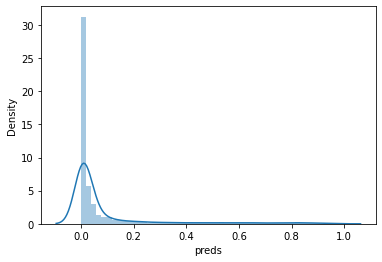

In [ ]:
import seaborn as sns
sns.distplot(oof_df["preds"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


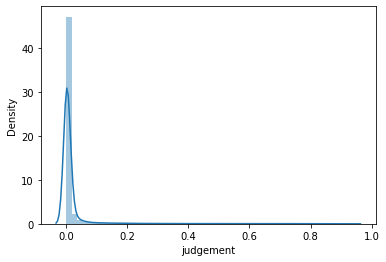

In [ ]:
import seaborn as sns
sns.distplot(pred_df["judgement"])

## 学習#4(1:1)

In [ ]:
#学習#1のうち０ラベルの予測に近いデータを削除
#0,1ラベル比を1:1にする

oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df_10_1.csv")
oof_df = oof_df.iloc[:,2:]
oof_df_negative = oof_df[oof_df.judgement ==0].sort_values("preds",ascending=True).reset_index(drop=True)
oof_df_positive = oof_df[oof_df.judgement ==1]

cut_line=len(oof_df) - 624*2
oof_df_negative = oof_df_negative[cut_line:]
train = pd.concat([oof_df_negative,oof_df_positive],axis=0).reset_index(drop=True)
train = get_train_data(train)

In [ ]:
train.judgement.value_counts()

1    624
0    624
Name: judgement, dtype: int64

In [ ]:
mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df_1_1.csv", index=False)



========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/62] Elapsed 0m 1s (remain 1m 14s) Loss: 0.7943 
Epoch: [1][61/62] Elapsed 1m 1s (remain 0m 0s) Loss: 0.7105 
EVAL: [0/8]Elapsed 0m 0s (remain 0m 5s)Loss: 0.2868


Epoch 1 - avg_train_loss: 0.7105  avg_val_loss: 0.7175  time: 67s
Epoch 1 - Score: 0.9803921568627451
Epoch 1 - Save Best Score: 0.9804 


EVAL: [7/8]Elapsed 0m 5s (remain 0m 0s)Loss: 0.7175


========== fold: 0 result ==========
Best_Border: -1.57942806
========== fold: 1 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/62] Elapsed 0m 1s (remain 1m 8s) Loss: 0.7247 
Epoch: [1][61/62] Elapsed 1m 0s (remain 0m 0s) Loss: 0.7203 
EVAL: [0/8]Elapsed 0m 0s (remain 0m 5s)Loss: 0.3986


Epoch 1 - avg_train_loss: 0.7203  avg_val_loss: 0.6615  time: 66s
Epoch 1 - Score: 0.9803921568627451
Epoch 1 - Save Best Score: 0.9804 


EVAL: [7/8]Elapsed 0m 5s (remain 0m 0s)Loss: 0.6615


========== fold: 1 result ==========
Best_Border: -1.57942806
========== fold: 2 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/62] Elapsed 0m 1s (remain 1m 7s) Loss: 0.7121 
Epoch: [1][61/62] Elapsed 1m 0s (remain 0m 0s) Loss: 0.6937 
EVAL: [0/8]Elapsed 0m 0s (remain 0m 5s)Loss: 0.4710


Epoch 1 - avg_train_loss: 0.6937  avg_val_loss: 0.6397  time: 66s
Epoch 1 - Score: 0.9803921568627451
Epoch 1 - Save Best Score: 0.9804 


EVAL: [7/8]Elapsed 0m 5s (remain 0m 0s)Loss: 0.6397


========== fold: 2 result ==========
Best_Border: -1.57942806
========== fold: 3 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/62] Elapsed 0m 1s (remain 1m 7s) Loss: 0.7428 
Epoch: [1][61/62] Elapsed 1m 0s (remain 0m 0s) Loss: 0.7175 
EVAL: [0/8]Elapsed 0m 0s (remain 0m 5s)Loss: 0.9036


Epoch 1 - avg_train_loss: 0.7175  avg_val_loss: 0.6701  time: 66s
Epoch 1 - Score: 0.9802371541501976
Epoch 1 - Save Best Score: 0.9802 


EVAL: [7/8]Elapsed 0m 5s (remain 0m 0s)Loss: 0.6701


========== fold: 3 result ==========
Best_Border: -1.57942806
========== fold: 4 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/62] Elapsed 0m 1s (remain 1m 5s) Loss: 0.7113 
Epoch: [1][61/62] Elapsed 1m 0s (remain 0m 0s) Loss: 0.6937 
EVAL: [0/8]Elapsed 0m 0s (remain 0m 5s)Loss: 0.6172


Epoch 1 - avg_train_loss: 0.6937  avg_val_loss: 0.6658  time: 66s
Epoch 1 - Score: 0.9805459679949796
Epoch 1 - Save Best Score: 0.9805 


EVAL: [7/8]Elapsed 0m 5s (remain 0m 0s)Loss: 0.6658


========== fold: 4 result ==========
Best_Border: -1.57942806
========== CV ==========
Best_Border: -1.57942806
Score: 0.98039


Best_Threshold：-1.5794280624162824
Best_Threshold：-1.5794280624162824
Best_Threshold：-1.5794280624162824


In [ ]:
pred_df=pd.read_csv(pred_dir +CONFIG.exp + "/pred_df_1_1.csv")
oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df_1_1.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


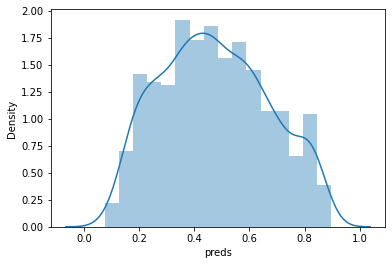

In [ ]:
import seaborn as sns
sns.distplot(oof_df["preds"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


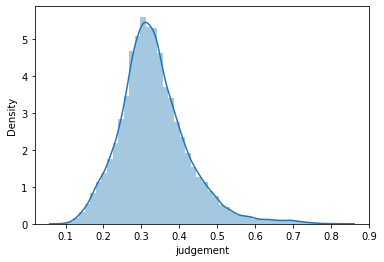

In [ ]:
import seaborn as sns
sns.distplot(pred_df["judgement"])

## 予測#4(1:1)

In [ ]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df_1_1.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission_1_1.csv", index=False, header=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [13:50<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [13:49<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [13:49<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [13:48<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 in

## 学習#5(0.5:1)

In [ ]:
#学習#1のうち０ラベルの予測に近いデータを削除
#0,1ラベル比を1:1にする

oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df_10_1.csv")
oof_df = oof_df.iloc[:,2:]
oof_df_negative = oof_df[oof_df.judgement ==0].sort_values("preds",ascending=True).reset_index(drop=True)
oof_df_positive = oof_df[oof_df.judgement ==1]

cut_line=int(len(oof_df) - 624*1.5)
oof_df_negative = oof_df_negative[cut_line:]
train = pd.concat([oof_df_negative,oof_df_positive],axis=0).reset_index(drop=True)
train = get_train_data(train)

In [ ]:
train.judgement.value_counts()

1    624
0    312
Name: judgement, dtype: int64

In [ ]:
mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df_05_1.csv", index=False)

========== fold: 0 training ==========
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/46] Elapsed 0m 1s (remain 0m 54s) Loss: 0.7385 
Epoch: [1][45/46] Elapsed 0m 46s (remain 0m 0s) Loss: 0.6945 
EVAL: [0/6]Elapsed 0m 0s (remain 0m 4s)Loss: 1.0866


Epoch 1 - avg_train_loss: 0.6945  avg_val_loss: 0.6639  time: 51s
Epoch 1 - Score: 0.9900205924283223
Epoch 1 - Save Best Score: 0.9900 


EVAL: [5/6]Elapsed 0m 3s (remain 0m 0s)Loss: 0.6639


========== fold: 0 result ==========
Best_Border: -1.57942806
========== fold: 1 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/46] Elapsed 0m 1s (remain 0m 50s) Loss: 0.7041 
Epoch: [1][45/46] Elapsed 0m 45s (remain 0m 0s) Loss: 0.6603 
EVAL: [0/6]Elapsed 0m 0s (remain 0m 4s)Loss: 1.1076


Epoch 1 - avg_train_loss: 0.6603  avg_val_loss: 0.5999  time: 50s
Epoch 1 - Score: 0.9899409228804088
Epoch 1 - Save Best Score: 0.9899 


EVAL: [5/6]Elapsed 0m 4s (remain 0m 0s)Loss: 0.5999


========== fold: 1 result ==========
Best_Border: -1.57942806
========== fold: 2 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/46] Elapsed 0m 1s (remain 0m 52s) Loss: 0.7350 
Epoch: [1][45/46] Elapsed 0m 45s (remain 0m 0s) Loss: 0.6520 
EVAL: [0/6]Elapsed 0m 0s (remain 0m 4s)Loss: 1.2629


Epoch 1 - avg_train_loss: 0.6520  avg_val_loss: 0.6327  time: 50s
Epoch 1 - Score: 0.9901774397972115
Epoch 1 - Save Best Score: 0.9902 


EVAL: [5/6]Elapsed 0m 4s (remain 0m 0s)Loss: 0.6327


========== fold: 2 result ==========
Best_Border: -1.57942806
========== fold: 3 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/46] Elapsed 0m 1s (remain 0m 52s) Loss: 0.6917 
Epoch: [1][45/46] Elapsed 0m 45s (remain 0m 0s) Loss: 0.7010 
EVAL: [0/6]Elapsed 0m 0s (remain 0m 4s)Loss: 1.0375


Epoch 1 - avg_train_loss: 0.7010  avg_val_loss: 0.5996  time: 50s
Epoch 1 - Score: 0.9901774397972115
Epoch 1 - Save Best Score: 0.9902 


EVAL: [5/6]Elapsed 0m 4s (remain 0m 0s)Loss: 0.5996


========== fold: 3 result ==========
Best_Border: -1.57942806
========== fold: 4 training ==========


Best_Threshold：-1.5794280624162824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/46] Elapsed 0m 1s (remain 0m 55s) Loss: 0.7357 
Epoch: [1][45/46] Elapsed 0m 45s (remain 0m 0s) Loss: 0.6484 
EVAL: [0/6]Elapsed 0m 0s (remain 0m 4s)Loss: 0.9303


Epoch 1 - avg_train_loss: 0.6484  avg_val_loss: 0.6115  time: 50s
Epoch 1 - Score: 0.9901774397972115
Epoch 1 - Save Best Score: 0.9902 


EVAL: [5/6]Elapsed 0m 4s (remain 0m 0s)Loss: 0.6115


========== fold: 4 result ==========
Best_Border: -1.57942806
========== CV ==========
Best_Border: -1.57942806
Score: 0.99010


Best_Threshold：-1.5794280624162824
Best_Threshold：-1.5794280624162824
Best_Threshold：-1.5794280624162824


## 予測#5(0.5:1)

In [ ]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df_05_1.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission_05_1.csv", index=False, header=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [13:46<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [13:47<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [13:48<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [13:49<00:00,  1.54it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 in

## 単純なアンサンブル

## Light GBM